In [1]:
# Disable reloading to prevent unnecessary numba recompilation
%load_ext autoreload
%autoreload 2

In [2]:
from neurkal.kalmanbasisnetwork import _calc_activity
import neurkal
import neurkal.utils as utils

import cProfile
import itertools
from os import environ
import pstats
import time

#import ipympl
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#from mpl_toolkits.mplot3d import Axes3D
import numba as nb
import numpy as np
from scipy.misc import derivative
import seaborn as sns

In [ ]:
%load_ext line_profiler

In [7]:
%matplotlib inline
# make Numpy raise warnings as exceptions (or not)
np.seterr(all='warn')
#np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [6]:
## Plot style setup
sns.set_style("ticks", {'font_scale': 1.5})
set_palette = lambda: itertools.cycle(sns.color_palette('deep'))
#sns.set(font_scale=1.5)

In [30]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.003]]   # constant "motor" dynamics
Z = [[0.001]]  # motor noise variance
c = np.array([[1]])

In [118]:
# simulation parameters
D = 1 
p = 30  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 10000
t_f = 100
ts = np.linspace(0, t_f, steps)

change = True
dx_change = 25

prior = True
x_prior = 0.0

In [119]:
K_w = 3
mu = 0.001
eta = 0.01

In [128]:
def input_act(x, prefs):
    act = 3 * (2 * np.exp(1 * (np.cos(np.deg2rad(x - prefs)) - 1)) + 0.01)
    return act

In [175]:
## initial state and network setup
state = neurkal.LinearDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

In [112]:
print(meas[0])
print(inputs[0].shape, activities[0].shape, estimates[0].shape, meas[0], gains[0])

6.346482805815742
(30,) (30,) (1,) 6.346482805815742 0.02663204682349573


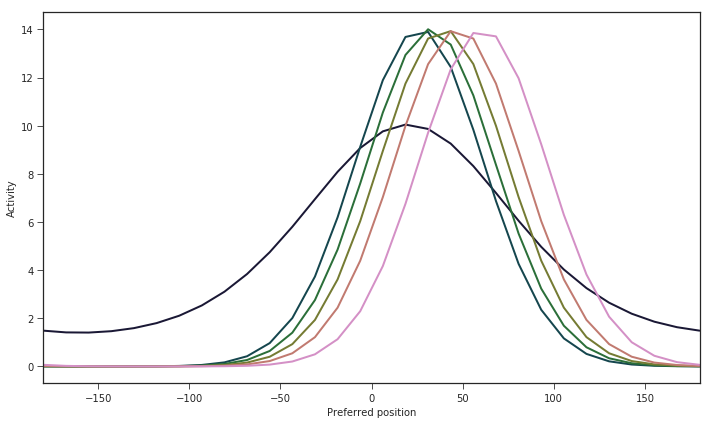

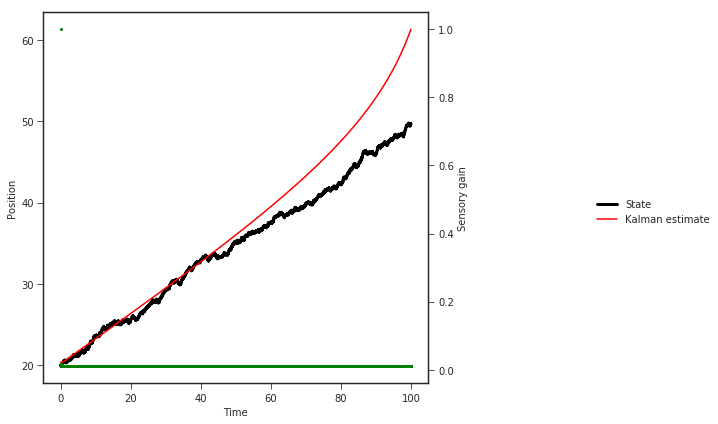

In [113]:
## Kalman network test -- only initial feedback

inputs = []
activities = []
states = []
estimates = []
gains = []

sensory_input(state.x[0], certain=True)

for i, t in enumerate(ts):
    inputs.append(np.copy(sensory_input.activity))
    states.append(state.x[0])
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    kalman_network.update()
    estimates.append(kalman_network.estimate)
    activities.append(kalman_network.activity)
    
    # update real state (+ control noise)
    state.update(c)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs

# plot of network activity over time
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 6
ps = []
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
#labels = [p.get_label() for p in ps]
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
#ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=4)

ps = [p1, p2]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

In [185]:
## Kalman network test: state estimates at each timestep
dtype = np.dtype([("state", 'f8', D), ("inputs", 'f8', (D, p)), ("activity", 'f8', (1, p)), 
                  ("estimate", 'f8', D), ("input_readouts", 'f8', D), ("sensory_gains", 'f8', D)])

record = np.zeros(len(ts), dtype=dtype)

def iterate_network(ts_):
    
    for i, t in enumerate(ts_):
        if prior and not i:
            sensory_input(np.array([x_prior]))  # prior
            kalman_network.update(first=True)
        else:
            sensory_input(state.x[0])
            kalman_network.update()

        record[i] = (state.x[0], [sensory_input.activity], [kalman_network.activity], kalman_network.estimate,
                     sensory_input.readout(), kalman_network.lam[0])
        
        # update real state (+ control noise)
        if change and i == int(0.5 * steps):
            state.initialize(state.x - dx_change)

        state.update(c)


cProfile.run('iterate_network(ts)', 'kalnet_stats_numba')

abs_errors = np.abs(record["state"] - record["estimate"])
abs_errors_norm = np.ravel(abs_errors / np.max(abs_errors))

log_gain = -np.log(np.array(record["sensory_gains"]))

In [ ]:
# profile kalman_network.update line-by-line
sensory_input(state.x[0])
%lprun -T kalnet_linestats_update -f kalman_network.update kalman_network.update()

In [ ]:
%lprun -T kalnet_linestats_numba -f iterate_network iterate_network(ts)

In [ ]:
ps = pstats.Stats('kalnet_stats_numba')
ps.sort_stats('tottime')
ps.print_stats(25)

In [ ]:
ps.print_callers(25)

In [ ]:
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.cubehelix_palette(8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
ps.append(ax1.plot(prefs, activities[1], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(2, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

None

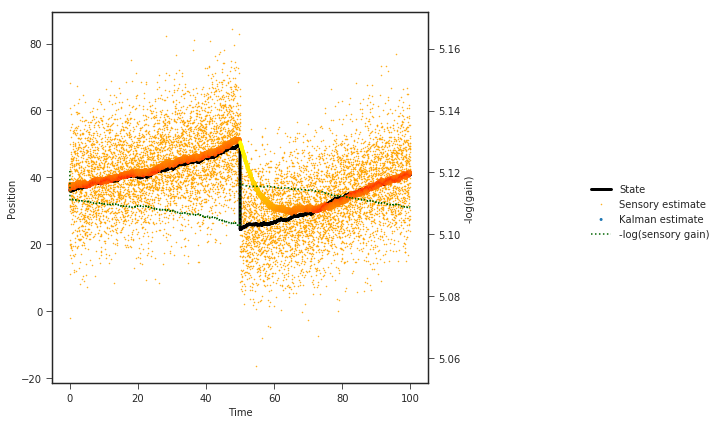

In [186]:
# plot of estimates and sensory gains over time
handle = display(None, display_id=True)
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
#ax1.set_ylim([-40, 60])

p4, = ax1.plot(ts, record["input_readouts"], '.', color='orange', label="Sensory estimate", ms=1) 
p1, = ax1.plot(ts, record["state"], '-', color='k', label="State", lw=3)
p2 = ax1.scatter(ts, record["estimate"], c=abs_errors ** 0.25, marker='.', alpha=1, label="Kalman estimate", linewidths=0.1, cmap='autumn', edgecolors='none', zorder=5)#'-', color='r', label="Kalman estimate", markerfacecolor='none', lw=0.5)
ax2 = ax1.twinx()
ax2.set_ylabel("-log(gain)")
ax2.set_ylim([0.99 * np.min(log_gain), 1.01 * np.max(log_gain)])
p3, = ax2.plot(ts, log_gain, ':', color='darkgreen', label="-log(sensory gain)", ms=5)
#p5, = ax2.plot(ts, errors, ':', color='m', label="Absolute error", markerfacecolor='none', lw=0.5)

ps = [p1, p4, p2, p3]#, p5]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
fig.savefig('test.png')
pp.close()

In [ ]:
plot_step = 5
fig = plt.figure()
ax = fig.gca(projection='3d')
prefs_, ts_ = np.meshgrid(range(p), range(0, steps, plot_step))
act = np.array(activities)[::plot_step]
surf = ax.plot_surface(prefs_, ts_, act, linewidth=0)
plt.show()

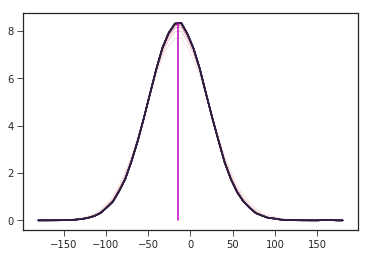

In [54]:
# test readout convergence
its = 15
ro = kalman_network.readout(iterations=its)
p_palette = itertools.cycle(sns.cubehelix_palette(its))
for i in range(its):
    plt.plot(kalman_network.prefs, kalman_network.readout_activity[i], color=next(p_palette), lw=np.sqrt(i/5))
plt.plot([ro] * 2, [0, np.max(kalman_network.readout_activity[-1])], 'm')
plt.show()

In [ ]:
prefs = sensory_input.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn3.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, inputs[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
#fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()


In [574]:
# dynamical parameters
M = [[1, 0.5],
     [0, 0.9]]  # internal model dynamics
B = [[0],
     [1]]   # constant "motor" dynamics
Z = [[0.001, 0],
     [0, 0.001]]  # motor noise variance
c = np.array([[0],
              [1]])

In [575]:
# simulation parameters
p = 20  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 100
t_f = 100
ts = np.linspace(0, t_f, steps)

In [576]:
K_w = 3
mu = 0.001
eta = 0.005

In [577]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

In [584]:
## Kalman network test: 1D arm position
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

dx_change = [[50], [0]]

# network initialization
sensory_inputs = [neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson),
                  neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson)]
motor_input = neurkal.PopCode(p, space=th_r, act_func=input_act, dist=lambda x: x)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=sensory_inputs, 
                                            motor_inputs=[motor_input], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
activities = []
estimates = []
meas = []
gains = []


for i, t in enumerate(ts):
    if i:
        sensory_input(state.x[0])
        kalman_network.update()
    else:
        sensory_input(np.array([0.0]))  # prior
        kalman_network.update(first=True)
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    #sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    
    # update real state (+ control noise)
    if i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)
    
    
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

ValueError: setting an array element with a sequence.